<a href="https://colab.research.google.com/github/OverfitSurvivor/code/blob/main/%EB%8C%80%ED%9A%8C_for_%EB%93%9C%EB%A1%A0A_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

zip_path = "/content/ICSV31AIChallengeDataset.zip"  # ÏóÖÎ°úÎìúÌïú ZIP ÌååÏùº Í≤ΩÎ°ú
extract_path = "/content/ICSV31AIChallengeDataset"  # ÏïïÏ∂ïÏùÑ ÌíÄ Ìè¥Îçî Í≤ΩÎ°ú

# Ìè¥ÎçîÍ∞Ä ÏóÜÏúºÎ©¥ ÏÉùÏÑ±
os.makedirs(extract_path, exist_ok=True)

# ÏïïÏ∂ï Ìï¥Ï†ú
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("ÏïïÏ∂ï Ìï¥Ï†ú ÏôÑÎ£å:", extract_path)


ÏïïÏ∂ï Ìï¥Ï†ú ÏôÑÎ£å: /content/ICSV31AIChallengeDataset


Epoch 1, Loss: 0.184770
Epoch 2, Loss: 0.085808
Epoch 3, Loss: 0.068293
Epoch 4, Loss: 0.059947
Epoch 5, Loss: 0.053938
Epoch 6, Loss: 0.050199
Epoch 7, Loss: 0.048031
Epoch 8, Loss: 0.045863
Epoch 9, Loss: 0.044213
Epoch 10, Loss: 0.042958


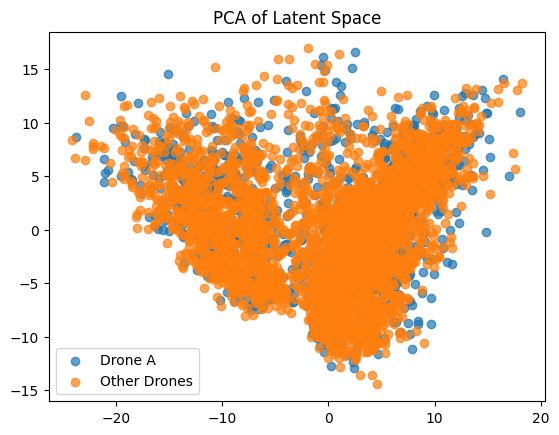

kNN Accuracy: 0.7229629629629629
SVM Accuracy: 0.7288888888888889


In [ ]:
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# AutoEncoder Î™®Îç∏ (Latent Vector Ï∂îÏ∂ú Í∞ÄÎä•ÌïòÎèÑÎ°ù)
class WaveNetAutoencoder(nn.Module):
    def __init__(self, input_channels, latent_dim=16):  # Latent Space ÌÅ¨Í∏∞ ÏÑ§Ï†ï
        super(WaveNetAutoencoder, self).__init__()

        # Ïù∏ÏΩîÎçî
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, latent_dim, kernel_size=3, padding=1)  # Latent Space
        )

        # ÎîîÏΩîÎçî
        self.decoder = nn.Sequential(
            nn.Conv1d(latent_dim, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, input_channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded  # Latent Vector & Î≥µÏõê Îç∞Ïù¥ÌÑ∞ Î∞òÌôò

# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨
def extract_features(file_path, sr=16000, n_mels=64):
    y, sr = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Ï†ïÍ∑úÌôî (z-score)
    mean = np.mean(log_mel_spec)
    std = np.std(log_mel_spec)
    log_mel_spec = (log_mel_spec - mean) / (std + 1e-6)

    return log_mel_spec[np.newaxis, :, :]

# ÎìúÎ°† Ïú†Ìòï(A, B, C) Ï∂îÏ∂úÌïòÎäî Ìï®Ïàò
def get_drone_type(file_name):
    match = re.search(r'train_(A|B|C)_', file_name)  # Ï†ïÍ∑ú ÌëúÌòÑÏãùÏúºÎ°ú ÎìúÎ°† ÌÉÄÏûÖ Ï∂îÏ∂ú
    if match:
        return match.group(1)  # A, B, C Ï§ë ÌïòÎÇò Î∞òÌôò
    return None  # ÏùºÏπòÌïòÎäî ÎìúÎ°† Ïú†ÌòïÏù¥ ÏóÜÏúºÎ©¥ None Î∞òÌôò

# ÎìúÎ°† A Îç∞Ïù¥ÌÑ∞ÏôÄ Îã§Î•∏ ÎìúÎ°† Îç∞Ïù¥ÌÑ∞ Î∂ÑÎ¶¨
def load_audio_data(folder_path, target_drone="A"):
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    drone_A_files = [f for f in files if get_drone_type(f) == target_drone]
    other_drone_files = [f for f in files if get_drone_type(f) != target_drone]

    drone_A_data = np.array([extract_features(os.path.join(folder_path, f)) for f in drone_A_files], dtype=np.float32)
    other_drone_data = np.array([extract_features(os.path.join(folder_path, f)) for f in other_drone_files], dtype=np.float32)

    return drone_A_data, other_drone_data

def create_dataloader(data, batch_size=32):
    tensor_data = torch.tensor(data, dtype=torch.float32)
    dataset = TensorDataset(tensor_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Latent Vector Ï∂îÏ∂ú Ìï®Ïàò
def extract_latent_vectors(model, data_loader):
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs[0].to(device).squeeze(1)
            encoded, _ = model(inputs)  # Latent Vector Ï∂îÏ∂ú
            latent_vectors.append(encoded.cpu().numpy())

    return np.concatenate(latent_vectors, axis=0).reshape(len(data_loader.dataset), -1)

# Î™®Îç∏ ÌïôÏäµ Î∞è Latent Vector Ï∂îÏ∂ú
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dir = "/content/ICSV31AIChallengeDataset/train"

# ÎìúÎ°† AÏôÄ Îã§Î•∏ ÎìúÎ°† Îç∞Ïù¥ÌÑ∞ Î°úÎìú
train_data_A, train_data_other = load_audio_data(train_dir, target_drone="A")

# A ÎìúÎ°†ÏùÄ 1, Îã§Î•∏ ÎìúÎ°†ÏùÄ 0ÏúºÎ°ú ÎùºÎ≤®ÎßÅ
labels_A = np.ones(len(train_data_A))
labels_other = np.zeros(len(train_data_other))

# Îç∞Ïù¥ÌÑ∞ Ìï©ÏπòÍ∏∞
train_data = np.vstack([train_data_A, train_data_other])
train_labels = np.hstack([labels_A, labels_other])

train_loader = create_dataloader(train_data)

# Î™®Îç∏ Ï†ïÏùò Î∞è ÌïôÏäµ
input_channels = train_data.shape[2]  # train_data.shape[2]ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Ï±ÑÎÑê ÏàòÎ•º Í∞ÄÏ†∏ÏòµÎãàÎã§.
model = WaveNetAutoencoder(input_channels, latent_dim=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# AutoEncoder ÌïôÏäµ
for epoch in range(10):
    model.train()
    total_loss = 0
    for inputs in train_loader:
        inputs = inputs[0].to(device).squeeze(1)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.6f}")

# Latent Vector Ï∂îÏ∂ú Î∞è PCA Î∂ÑÏÑù
latent_vectors = extract_latent_vectors(model, train_loader)

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.scatter(latent_2d[train_labels == 1, 0], latent_2d[train_labels == 1, 1], label="Drone A", alpha=0.7)
plt.scatter(latent_2d[train_labels == 0, 0], latent_2d[train_labels == 0, 1], label="Other Drones", alpha=0.7)
plt.legend()
plt.title("PCA of Latent Space")
plt.show()

# kNN/SVMÏùÑ Ïù¥Ïö©Ìïú ÎìúÎ°† A Î∂ÑÎ•ò
X_train, y_train = latent_vectors, train_labels

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

print("kNN Accuracy:", accuracy_score(y_train, knn.predict(X_train)))
print("SVM Accuracy:", accuracy_score(y_train, svm.predict(X_train)))

Epoch 1, Loss: 0.299529
Epoch 2, Loss: 0.248420
Epoch 3, Loss: 0.242575
Epoch 4, Loss: 0.239206
Epoch 5, Loss: 0.236708
Epoch 6, Loss: 0.234668
Epoch 7, Loss: 0.233569
Epoch 8, Loss: 0.232352
Epoch 9, Loss: 0.231036
Epoch 10, Loss: 0.230163
Epoch 11, Loss: 0.229312
Epoch 12, Loss: 0.228534
Epoch 13, Loss: 0.227585
Epoch 14, Loss: 0.226999
Epoch 15, Loss: 0.226488
Epoch 16, Loss: 0.225631
Epoch 17, Loss: 0.224875
Epoch 18, Loss: 0.224363
Epoch 19, Loss: 0.223993
Epoch 20, Loss: 0.223598
Epoch 21, Loss: 0.223351
Epoch 22, Loss: 0.223085
Epoch 23, Loss: 0.222697
Epoch 24, Loss: 0.222858
Epoch 25, Loss: 0.222471
Epoch 26, Loss: 0.222217
Epoch 27, Loss: 0.221913
Epoch 28, Loss: 0.221583
Epoch 29, Loss: 0.221579
Epoch 30, Loss: 0.221257
Epoch 31, Loss: 0.221273
Epoch 32, Loss: 0.220756
Epoch 33, Loss: 0.221263
Epoch 34, Loss: 0.220613
Epoch 35, Loss: 0.220715
Epoch 36, Loss: 0.220550
Epoch 37, Loss: 0.220614
Epoch 38, Loss: 0.220247
Epoch 39, Loss: 0.220266
Epoch 40, Loss: 0.220221
Epoch 41,

<ipython-input-5-7d1622076e6e>:175: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


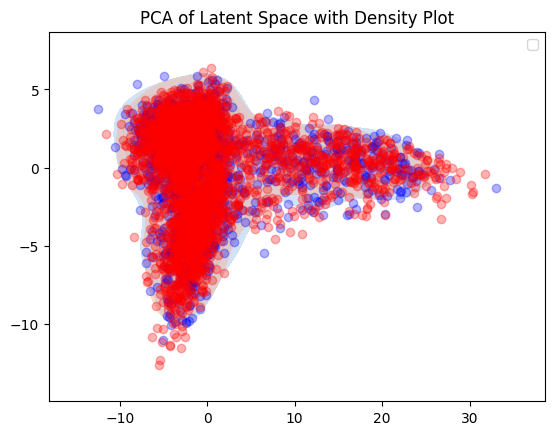

kNN Accuracy (Cross-Validation): 0.5987
SVM Accuracy (Cross-Validation): 0.5717


In [ ]:
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from joblib import Parallel, delayed

# -------------------------------
# AutoEncoder Î™®Îç∏ Ï†ïÏùò (Latent Vector Ï∂îÏ∂ú Í∞ÄÎä•)
# -------------------------------
class WaveNetAutoencoder(nn.Module):
    def __init__(self, input_channels, latent_dim=16):
        super(WaveNetAutoencoder, self).__init__()

        # Ïù∏ÏΩîÎçî
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, latent_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )

        # ÎîîÏΩîÎçî
        self.decoder = nn.Sequential(
            nn.Conv1d(latent_dim, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, input_channels, kernel_size=3, padding=1),
            nn.Tanh()  # Ï∂úÎ†•Í∞í ÏïàÏ†ïÌôî
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# -------------------------------
# Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
# -------------------------------
def extract_features(file_path, sr=16000, n_mels=64):
    y, sr = librosa.load(file_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Ï†ïÍ∑úÌôî (z-score)
    mean = np.mean(log_mel_spec)
    std = np.std(log_mel_spec)
    log_mel_spec = (log_mel_spec - mean) / (std + 1e-6)

    return log_mel_spec[np.newaxis, :, :]

# ÎìúÎ°† Ïú†Ìòï(A, B, C) Ï∂îÏ∂ú
def get_drone_type(file_name):
    match = re.search(r'train_(A|B|C)_', file_name)
    return match.group(1) if match else None

# Îç∞Ïù¥ÌÑ∞ Î°úÎìú (Î≥ëÎ†¨ Ï≤òÎ¶¨ Ï†ÅÏö©)
def load_audio_data(folder_path, target_drone="A", n_jobs=-1):
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    drone_A_files = [f for f in files if get_drone_type(f) == target_drone]
    other_drone_files = [f for f in files if get_drone_type(f) != target_drone]

    drone_A_data = Parallel(n_jobs=n_jobs)(delayed(extract_features)(os.path.join(folder_path, f)) for f in drone_A_files)
    other_drone_data = Parallel(n_jobs=n_jobs)(delayed(extract_features)(os.path.join(folder_path, f)) for f in other_drone_files)

    return np.array(drone_A_data, dtype=np.float32), np.array(other_drone_data, dtype=np.float32)

# DataLoader ÏÉùÏÑ±
def create_dataloader(data, batch_size=32):
    tensor_data = torch.tensor(data, dtype=torch.float32)
    dataset = TensorDataset(tensor_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# -------------------------------
# Latent Vector Ï∂îÏ∂ú Ìï®Ïàò
# -------------------------------
def extract_latent_vectors(model, data_loader):
    model.eval()
    latent_vectors = []

    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs[0].to(device).squeeze(1)
            encoded, _ = model(inputs)
            latent_vectors.append(encoded.cpu().numpy())

    return np.concatenate(latent_vectors, axis=0).reshape(len(data_loader.dataset), -1)

# -------------------------------
# Î™®Îç∏ ÌïôÏäµ Î∞è Latent Vector Ï∂îÏ∂ú
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dir = "/content/ICSV31AIChallengeDataset/train"

# ÎìúÎ°† AÏôÄ Îã§Î•∏ ÎìúÎ°† Îç∞Ïù¥ÌÑ∞ Î°úÎìú
train_data_A, train_data_other = load_audio_data(train_dir, target_drone="A")

# A ÎìúÎ°†ÏùÄ 1, Îã§Î•∏ ÎìúÎ°†ÏùÄ 0ÏúºÎ°ú ÎùºÎ≤®ÎßÅ
labels_A = np.ones(len(train_data_A))
labels_other = np.zeros(len(train_data_other))

# Îç∞Ïù¥ÌÑ∞ Î≥ëÌï©
train_data = np.vstack([train_data_A, train_data_other])
train_labels = np.hstack([labels_A, labels_other])

train_loader = create_dataloader(train_data)

# Î™®Îç∏ Ï†ïÏùò Î∞è ÌïôÏäµ
input_channels = train_data.shape[2]
model = WaveNetAutoencoder(input_channels, latent_dim=16).to(device)  # latent_dim Î∞îÍøîÍ∞ÄÎ©¥ÏÑú Ïã§Ìóò
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Early Stopping ÏÑ§Ï†ï
best_loss = float('inf')
patience = 3
wait = 0

for epoch in range(100):  # ÏµúÎåÄ 100 ÏóêÌè¨ÌÅ¨
    model.train()
    total_loss = 0
    for inputs in train_loader:
        inputs = inputs[0].to(device).squeeze(1)
        optimizer.zero_grad()
        _, outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")

    # Early Stopping Ï≤¥ÌÅ¨
    if avg_loss < best_loss:
        best_loss = avg_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early Stopping Activated!")
            break

# -------------------------------
# Latent Vector Î∂ÑÏÑù (PCA)
# -------------------------------
latent_vectors = extract_latent_vectors(model, train_loader)

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

sns.kdeplot(x=latent_2d[train_labels == 1, 0], y=latent_2d[train_labels == 1, 1], fill=True, alpha=0.5, label="Drone A")
sns.kdeplot(x=latent_2d[train_labels == 0, 0], y=latent_2d[train_labels == 0, 1], fill=True, alpha=0.5, label="Other Drones")
plt.scatter(latent_2d[train_labels == 1, 0], latent_2d[train_labels == 1, 1], alpha=0.3, color='blue')
plt.scatter(latent_2d[train_labels == 0, 0], latent_2d[train_labels == 0, 1], alpha=0.3, color='red')
plt.legend()
plt.title("PCA of Latent Space with Density Plot")
plt.show()

üìå ÎìúÎ°† A ÌèâÍ∑† Ï¢åÌëú: [0.02773181 0.07023753], Î∂ÑÏÇ∞: [42.55027   8.602611]
üìå Îã§Î•∏ ÎìúÎ°† ÌèâÍ∑† Ï¢åÌëú: [-0.01386882 -0.0351131 ], Î∂ÑÏÇ∞: [39.931137  9.064468]
 ÌÅ¥ÎûòÏä§ Í∞Ñ Ï§ëÏã¨ Í±∞Î¶¨ (Euclidean Distance): 0.1133
T-test Í≤∞Í≥º: t-statistic=[0.22555774 1.222351  ], p-value=[0.82155395 0.22162831]


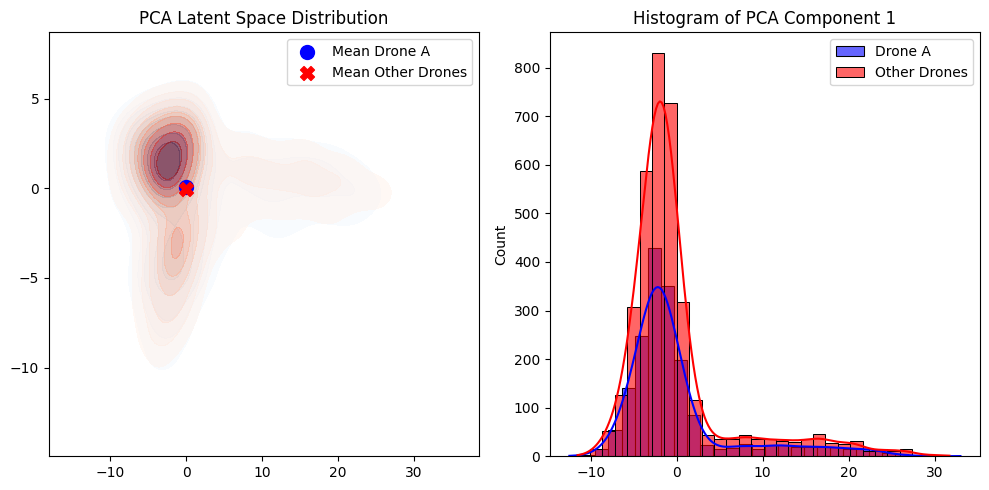

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_ind

# ÎìúÎ°† AÏôÄ Îã§Î•∏ ÎìúÎ°†Ïùò PCA Î≥ÄÌôòÎêú Í∞í Î∂ÑÎ¶¨
latent_A = latent_2d[train_labels == 1]
latent_other = latent_2d[train_labels == 0]

# 1. ÌèâÍ∑† Î∞è Î∂ÑÏÇ∞ ÎπÑÍµê
mean_A, var_A = np.mean(latent_A, axis=0), np.var(latent_A, axis=0)
mean_other, var_other = np.mean(latent_other, axis=0), np.var(latent_other, axis=0)

print(f"üìå ÎìúÎ°† A ÌèâÍ∑† Ï¢åÌëú: {mean_A}, Î∂ÑÏÇ∞: {var_A}")
print(f"üìå Îã§Î•∏ ÎìúÎ°† ÌèâÍ∑† Ï¢åÌëú: {mean_other}, Î∂ÑÏÇ∞: {var_other}")

# 2. Îëê ÌÅ¥ÎûòÏä§ Í∞Ñ Ï§ëÏã¨ Í±∞Î¶¨ (Euclidean Distance)
center_distance = euclidean(mean_A, mean_other)
print(f" ÌÅ¥ÎûòÏä§ Í∞Ñ Ï§ëÏã¨ Í±∞Î¶¨ (Euclidean Distance): {center_distance:.4f}")

# 3. Î∂ÑÌè¨ Ï∞®Ïù¥Î•º ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú Í≤ÄÏ¶ù (t-test)
t_stat, p_value = ttest_ind(latent_A, latent_other)
print(f"T-test Í≤∞Í≥º: t-statistic={t_stat}, p-value={p_value}")

# 4. ÏãúÍ∞ÅÌôî (KDE Plot & ÌûàÏä§ÌÜ†Í∑∏Îû®)
plt.figure(figsize=(10, 5))

# KDE Plot
plt.subplot(1, 2, 1)
# xÏôÄ y ÌÇ§ÏõåÎìú Ïù∏ÏàòÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Îëê Î≥ÄÏàòÏùò Í¥ÄÍ≥ÑÎ•º ÏãúÍ∞ÅÌôî
sns.kdeplot(x=latent_A[:, 0], y=latent_A[:, 1], cmap="Blues", fill=True, alpha=0.5, label="Drone A")
sns.kdeplot(x=latent_other[:, 0], y=latent_other[:, 1], cmap="Reds", fill=True, alpha=0.5, label="Other Drones")
plt.scatter(mean_A[0], mean_A[1], color="blue", marker="o", s=100, label="Mean Drone A")
plt.scatter(mean_other[0], mean_other[1], color="red", marker="X", s=100, label="Mean Other Drones")
plt.legend()
plt.title("PCA Latent Space Distribution")

# ÌûàÏä§ÌÜ†Í∑∏Îû® (Ï≤´ Î≤àÏß∏ Ï£ºÏÑ±Î∂Ñ)
plt.subplot(1, 2, 2)
sns.histplot(latent_A[:, 0], bins=30, color='blue', alpha=0.6, label="Drone A", kde=True)
sns.histplot(latent_other[:, 0], bins=30, color='red', alpha=0.6, label="Other Drones", kde=True)
plt.legend()
plt.title("Histogram of PCA Component 1")

plt.tight_layout()
plt.show()